# PIERS Data Exploration

This notebook addresses missing data and other issues in the PIERS BOL data, and provides basic exploratory analysis of the database. Data is exported from this notebook in form(s) relevant to intended modeling. 

In [1]:
import pandas as pd #v2.1.3
import polars as pl #v0.20.7
import plotly_express as px #v0.4.1 
import missingno as msno #v0.5.2
import datetime as dt
from polars.testing import assert_frame_equal
from sklearn.cluster import HDBSCAN
import time


#display settings
pd.set_option('display.max_columns', None)

#enable string cache for polars categoricals
pl.enable_string_cache()

begin = time.time()

Convenience steps:
- drop unused columns
- create lane_name column
- get most commonly used SCAC and name for each carrier

In [2]:
#set paths
imports_path = 'data/raw_parquet/imports/'
exports_path = 'data/raw_parquet/exports/'
#init lazy dataframes
imports_lf = (
    pl.scan_parquet(imports_path+'*.parquet', parallel='columns')
    #drop unused columns 
    .select(
        'weight',
        'weight_unit',
        'qty',
        'qty_type',
        'teus',
        #'value_est',
        'date',
        'container_piece_count',
        'commod_short_desc_qty',
        'origin_territory',
        'origin_region',
        'arrival_port_code',
        'arrival_port_name',
        'departure_port_code',
        'departure_port_name',
        #'dest_final',
        'coast_region',
        #'clearing_district',
        #'place_receipt',
        #'shipper_name',
        #'shipper_address',
        #'consignee_name',
        #'consignee_address',
        #'notify_party1_name',
        #'notify_party1_address',
        #'notify_party2_name',
        #'notify_party2_address',
        #'commod_desc_raw',
        'container_id_marks',
        'marks_desc',
        'hs_code',
        'joc_code',
        'commod_short_desc',
        'container_ids',
        'carrier_name',
        'carrier_scac',
        'vessel_name',
        'voyage_number',
        #'precarrier',
        'vessel_id',
        #'inbond_code',
        #'transport_mode',
        'bol_number',
        'direction',
        'bol_id',
        'year',
        'month',
        'lane_id'
    )
    #get lane name 
    .with_columns(
            #find most commonly used departure port name for a given lane_id
            pl.col('departure_port_name').drop_nulls().mode().first().over('lane_id').alias('best_departure_port_name'),
            #find most commonly used arrival port name for a given lane_id
            pl.col('arrival_port_name').drop_nulls().mode().first().over('lane_id').alias('best_arrival_port_name')
        )
        .with_columns(
            (pl.col('best_departure_port_name').cast(pl.Utf8)+' — '+pl.col('best_arrival_port_name').cast(pl.Utf8))
            .str.to_titlecase()
            .cast(pl.Categorical)
            .alias('lane_name')
        )
        .drop('best_departure_port_name', 'best_arrival_port_name')
    #get most commonly used carrier name for each scac and vise-versa to normalize changes in names and codes 
    .with_columns(
        pl.col('carrier_name').drop_nulls().mode().first().over('carrier_scac')
        .alias('unified_carrier_name')
    )
    .with_columns(
        pl.col('carrier_scac').drop_nulls().mode().first().over('unified_carrier_name')
        .alias('unified_carrier_scac')
    )
)
exports_lf = (
    pl.scan_parquet(exports_path+'piers_exports_raw.parquet', parallel='columns') 
    #drop unused columns
    .select(
        #'shipper',
        #'shipper_address',
        'weight',
        'weight_unit',
        'qty',
        'quantity_type',
        'teus',
        'carrier_name',
        'carrier_scac',
        'vessel_name',
        'voyage_number',
        'bol_number',
        'vessel_id',
        'value_est',
        'departure_port_code',
        'departure_port_name',
        'container_ids',
        'container_piece_count',
        'coast_region',
        #'commod_desc_raw',
        'commod_short_desc',
        'hs_code',
        #'joc_code',
        'commod_short_desc_qty',
        'date',
        #'origin',
        'dest_territory',
        'dest_region',
        'arrival_port_code',
        'arrival_port_name',
        'direction',
        'bol_id',
        'year',
        'month',
        'lane_id'
    )
    #get lane name 
    .with_columns(
            #find most commonly used departure port name for a given lane_id
            pl.col('departure_port_name').drop_nulls().mode().first().over('lane_id').alias('best_departure_port_name'),
            #find most commonly used arrival port name for a given lane_id
            pl.col('arrival_port_name').drop_nulls().mode().first().over('lane_id').alias('best_arrival_port_name')
        )
        .with_columns(
            (pl.col('best_departure_port_name').cast(pl.Utf8)+' — '+pl.col('best_arrival_port_name').cast(pl.Utf8))
            .str.to_titlecase()
            .cast(pl.Categorical)
            .alias('lane_name')
        )
        .drop('best_departure_port_name', 'best_arrival_port_name')
    #get most commonly used carrier name and scac 
    .with_columns(
        pl.col('carrier_name').drop_nulls().mode().first().over('carrier_scac')
        .alias('unified_carrier_name')
    )
    .with_columns(
        pl.col('carrier_scac').drop_nulls().mode().first().over('unified_carrier_name')
        .alias('unified_carrier_scac')
    )
)

## Notebook functions

In [3]:
#fill nulls in volume cols with mean
def fill_volume(lf):
    '''ad hod function to fill volume columns with their means'''
    return (
        lf
        .with_columns([
            pl.col('teus').replace(0,None).fill_null(strategy='mean'),
            pl.col('weight').replace(0,None).fill_null(strategy='mean'),
            pl.col('qty').replace(0,None).fill_null(strategy='mean')
            ])
        )

#plotly graph inspecting nulls over time by group
def nulls_over_time_plotly(data_lf, group_var, time_var, value_var, title=False):
    '''
    Plots proportion of null values over time by group.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_var - str - the name of the column by which to group
        time_var - str - the name of the time column (e.g., year, month) over which values will be counted
        value_var - str - the name of the column containing the variable in question
        title (default=False) - str - the title of the graph
    OUTPUT:
        a plotly express figure
    DEPENDS ON:
        polars
        plotly express 
    '''
    df = (
        #select relevant columns
        data_lf.select([group_var, time_var, value_var])
        #group by, creating null count and non-null count cols
        .group_by(group_var, time_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        #compute percent null and fill new column
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        #cast group col to string to allow sensible ordering of legend
        .cast({group_var:pl.Utf8})
        #sort by date (to allow proper visualization of lines) and group (for legend ordering) 
        .sort(time_var, group_var)
    ).collect()
    #plot
    fig = px.line(
        data_frame=df,
        x=time_var, y='null_percent',
        color=group_var,
        title= 'Count of nulls over time by source frame.' if not title else title
    )
    fig.show()
    del df

#plotly graph inspecting nulls by group
def nulls_by_group_plotly(data_lf, group_var, value_var, title=False):
    '''Plots proportion of null values in the given groups'''
    df = (
        data_lf.select([group_var, value_var])
        .group_by(group_var)
        .agg([pl.col(value_var).null_count().alias('null_count'),
                pl.col(value_var).count().alias('count')])
        .with_columns((pl.col('null_count')/(pl.col('count')+pl.col('null_count'))).alias('null_percent'))
        .cast({group_var:pl.Utf8})
        .sort('null_percent', descending=True)
    ).collect()
    #plot
    fig = px.bar(
        data_frame=df,
        x=group_var, y='null_percent',
        title= 'Null percent by group.' if not title else title
    )
    fig.show()

#fill nulls over groups given a single unique value per group
def fill_nulls_by_group(data_lf, group_vars, val_var):
    '''Fills null values by group if and only if the val_var for that group contains exactly one non-null unique value.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_vars - iterable - the names of the columns by which groups will be created
        val_var - string - the name of the column in which nulls will be filled
    OUTPUT:
        filled_lf - the resultant lazyframe 
    DEPENDS ON:
        polars - current version written in polars 0.20.1
    '''
    filled_lf = (
        data_lf.with_columns(
            #if the group contains exactly one unique value: 
            pl.when(pl.col(val_var).drop_nulls().unique(maintain_order=True).len().over(group_vars)==1)
            #then fill the group with that value
            .then(pl.col(val_var).fill_null(pl.col(val_var).drop_nulls().unique(maintain_order=True).first().over(group_vars)))
            #otherwise do nothing
            .otherwise(pl.col(val_var))
            )
        )
    return filled_lf

def is_one2one(lf, col1, col2):
    '''checks if the two pl.LazyFrame columns constitute a 1-1 pairing'''
    forward = lf.group_by(col1).agg(pl.col(col2).drop_nulls().n_unique()).select(col2).max().collect().item() == 1
    back = lf.group_by(col2).agg(pl.col(col1).drop_nulls().n_unique()).select(col1).max().collect().item() == 1
    return (forward and back)

def count_unique_by_group(lf, group_vars, val_var):
    '''returns a dataframe of unique observations for the value variable over each group'''
    df = (
        lf.group_by(group_vars)
        .agg(
            pl.col(val_var).unique().alias('unique_values'),
            pl.col(val_var).n_unique().alias('n_unique')
        )
        .drop_nulls()
        .sort('n_unique', descending=True)
        .collect()
    )
    return df

def add_primary_carrier(lf):
    '''alternative ad hoc function to find primary carrier for each vessel and indicate cargo sharing'''
    lf = (
        lf.with_columns(
            pl.col('teus').sum()
            .over('vessel_id', 'month', 'unified_carrier_scac')
            .alias('sum_teus')
            )
        .with_columns(
            pl.col('unified_carrier_scac')
            .sort_by('sum_teus', descending=True)
            .drop_nulls().first()
            .over('vessel_id', 'month')
            .alias('vessel_owner')
            )
        #add bool col if bol is from primary carrier
        .with_columns(
            (pl.col('unified_carrier_scac')==pl.col('vessel_owner'))
            .alias('primary_cargo')
            )
    )
    return lf

def sharing_over_time_plotly(data_lf, group_var, include_missing_vessels=True, limit=10, title=False):
    '''
    Plots proportion of shared cargo over time (months) by group_var.
    INPUTS:
        data_lf - polars lazyframe containing the relevant data
        group_var - str - the name of the column by which to group
        include_missing_vessels - bool - default=True, when False, drops missing vessel_ids
        title (default=False) - str - the title of the graph
    OUTPUT:
        a plotly express figure
    DEPENDS ON:
        polars
        plotly express 
    '''
    if not include_missing_vessels:
        df = data_lf.drop_nulls('vessel_id')
    else:
        df = data_lf
    
    df = (
        #select relevant columns
        df.select([group_var, 'month', 'primary_cargo', 'teus'])
        #sum teus over each group-month-shared 
        .group_by(group_var, 'month')
        .agg(
            (pl.col('teus')*pl.col('primary_cargo')).sum().alias('total_primary'),
            pl.col('teus').sum().alias('total_teus')
        )
        #create proportion shared
        .with_columns((1-(pl.col('total_primary')/pl.col('total_teus'))).alias('prop_shared'))
        #cast group col to string to allow sensible ordering of legend
        .cast({group_var:pl.Utf8})
        #sort by date (to allow proper visualization of lines) and group (for legend ordering) 
        .sort('month')
    ).collect()

    #limit categories
    top_groups = (
        data_lf.group_by(group_var)
        .agg(pl.col('teus').sum())
        .sort('teus', descending=True)
        .select(group_var)
        .limit(limit)
        .collect()
        .to_series()
        .cast(pl.Utf8)
    )
    
    #plot
    fig = px.line(
        data_frame=df.filter(pl.col(group_var).is_in(top_groups)).with_columns(pl.col('month').str.to_datetime('%Y%m')),
        x='month', y='prop_shared',
        color=group_var,
        title= 'Proportion of shared cargo over time.' if not title else title,
        labels={
            'prop_shared':'Proportion of cargo from non-primary carrier',
            'month':'Month'
        }
    )
    fig.show()


## Missing Data

Major areas of missing data include:
- TEU and other volume data, especially prior to 2015
- vessel_id (IMO codes), especially in certain date windows
- Carriers are sometimes codes as "BULK" instead of the SCAC

Missing Values Matrix for Exports. 
The vertical axis corresponds to date, with earliest at the top.  
Note the daily aggregation counts the row as non-null if any value that day is non-null.


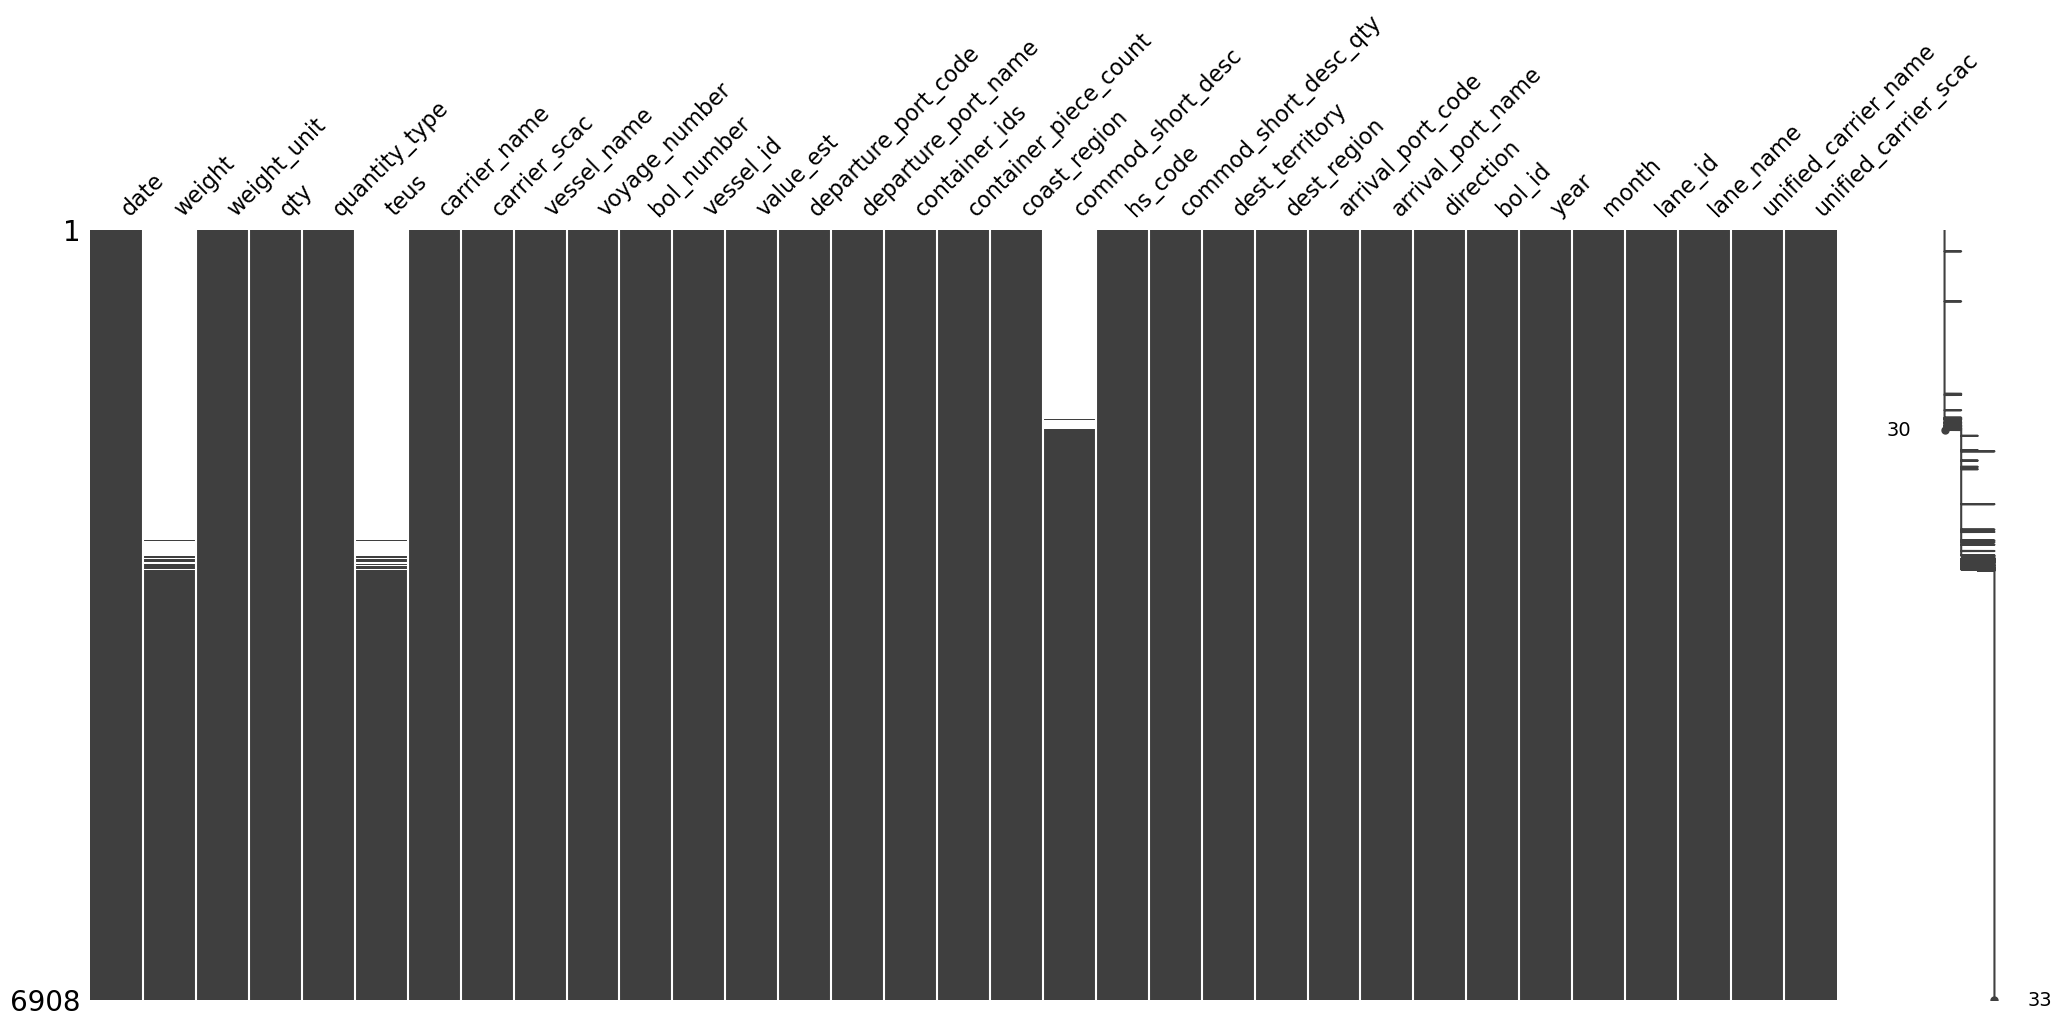

In [4]:
#%%script echo skipping
#MSNO provides a matrix visualization fo missing data; to deploy, comment out the %%script line. 
print('Missing Values Matrix for Exports. \nThe vertical axis corresponds to date, with earliest at the top.  \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    exports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date').sum()
    .sort('date')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

Missing Values Matrix for Imports. 
The vertical axis corresponds to date, with earliest at the top. 
Note the daily aggregation counts the row as non-null if any value that day is non-null.


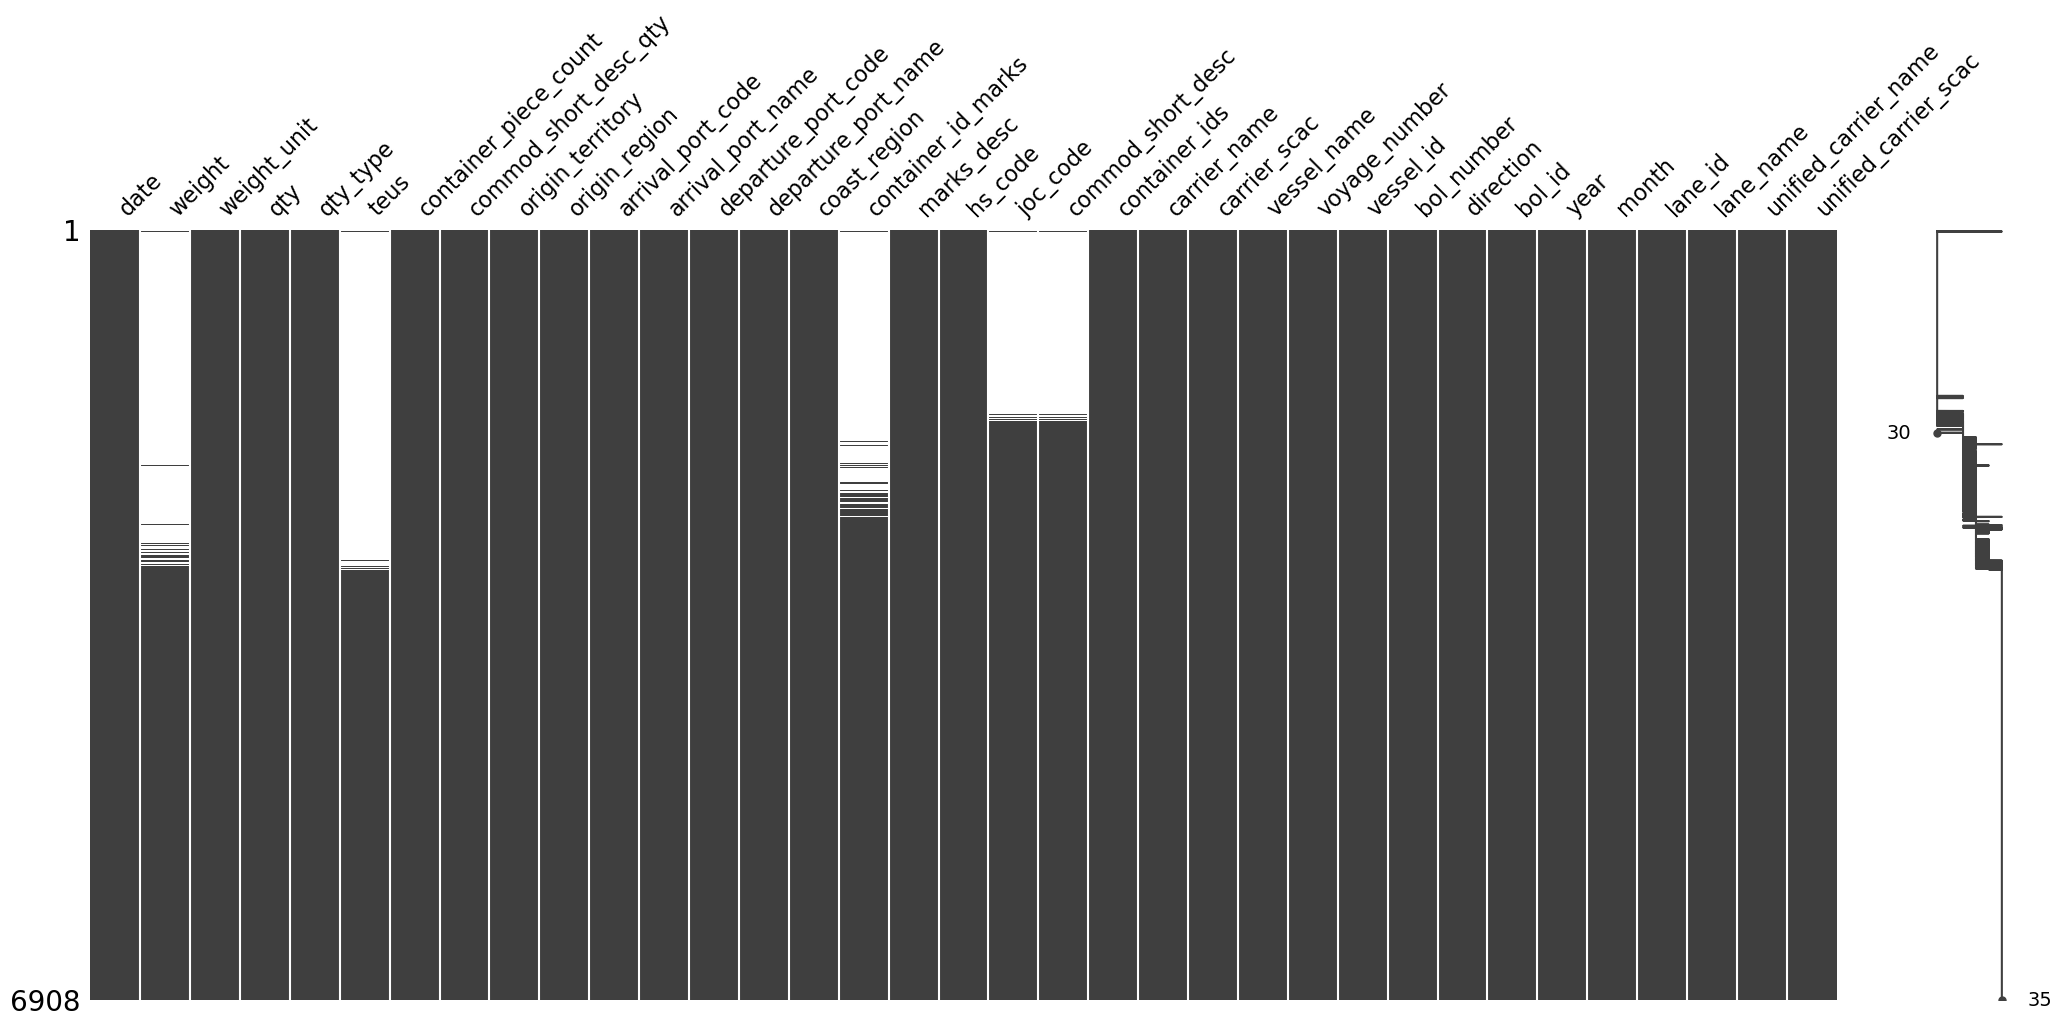

In [5]:
#%%script echo skipping
print('Missing Values Matrix for Imports. \nThe vertical axis corresponds to date, with earliest at the top. \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    imports_lf
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date').sum()
    .sort('date')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

### Zero values in TEU and other volume columns

For the time being, we fill missing volume data with the mean from non-zero observations. This step is expected to change as beter metadata is gathered. 

In [6]:
imports_lf = fill_volume(imports_lf)
exports_lf = fill_volume(exports_lf)    

### Missing Vessel and Voyage IDs

Identifying unique vessels and voyages is critical to studying how long each vessel remains in port, how often carriers utilize alliances (e.g., what proportion of a vessel's cargo is from another carrier), and other quality metrics. The issue is especially concerning given the high proportion (~30% in some time periods) of missing data, as can be seen below.

In [7]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'vessel_id'),
    exports_lf.select('direction', 'month', 'vessel_id')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_id',
    title='Proportion of Missing Vessel IDs over time (original data).')

In [8]:
lf = pl.concat(
    [imports_lf.select('direction', 'month', 'vessel_name'),
    exports_lf.select('direction', 'month', 'vessel_name')]
)

nulls_over_time_plotly(
    data_lf=lf,
    group_var='direction',
    time_var='month',
    value_var='vessel_name',
    title='Proportion of Missing Vessel Names over time (original data).')

## Primary Carrier

For any given voyage, we assign primary carrier based on the proportion of TEUs from each carrier imported/exported on that voyage (max proportion is primary carrier). 

In [9]:
#add primary carrier and shared cargo columns to lfs
imports_lf = add_primary_carrier(imports_lf)
exports_lf = add_primary_carrier(exports_lf)

In [10]:
lf = pl.concat([imports_lf,exports_lf], how='diagonal')

sharing_over_time_plotly(
    data_lf=lf,
    include_missing_vessels=False,
    group_var='direction')

In [11]:
sharing_over_time_plotly(
    data_lf=exports_lf,
    group_var='departure_port_name',
    title='Proportion of shared cargo over time (Top 10 export ports by total TEUs).')

In [12]:
sharing_over_time_plotly(
    data_lf=exports_lf,
    group_var='departure_port_name',
    include_missing_vessels=False,
    title='Proportion of shared cargo over time (Top 10 export ports by total TEUs).')

In [13]:
sharing_over_time_plotly(
    data_lf=exports_lf,
    group_var='lane_name',
    include_missing_vessels=False,
    title='Proportion of shared cargo over time (Top 10 export lanes by total TEUs).')

In [14]:
sharing_over_time_plotly(
    data_lf=imports_lf,
    group_var='lane_name',
    title='Proportion of shared cargo over time (Top 10 import lanes by total TEUs).')

In [15]:
sharing_over_time_plotly(
    data_lf=imports_lf,
    group_var='vessel_owner',
    include_missing_vessels=False,
    title='Proportion of shared cargo over time (Top 10 Vessel Owners by total TEUs imported).')

In [16]:
sharing_over_time_plotly(
    data_lf=exports_lf,
    group_var='vessel_owner',
    include_missing_vessels=False,
    title='Proportion of shared cargo over time (Top 10 Vessel Owners by total TEUs exported).')

In [17]:
#filter by MSC and Maersk controlled voyages
lf = (
    imports_lf.filter(
        pl.col('vessel_owner').is_in(['MEDU','MAEU']),
        pl.col('unified_carrier_scac').is_in(['MEDU','MAEU'])
    )
)
sharing_over_time_plotly(
    data_lf=lf,
    group_var='lane_name',
    include_missing_vessels=False,
    title='Proportion of shared cargo over time for MSC and Maersk vessels (Top 10 import lanes by total TEUs).')


In [18]:
#filter by MSC and Maersk controlled voyages
lf = (
    exports_lf.filter(
        pl.col('vessel_owner').is_in(['MSCU','MLSL']),
        pl.col('unified_carrier_scac').is_in(['MSCU','MLSL'])
    )
)
sharing_over_time_plotly(
    data_lf=lf,
    group_var='lane_name',
    include_missing_vessels=False,
    title='Proportion of shared cargo over time for MSC and Maersk vessels (Top 10 export lanes by total TEUs).')

### 'BULK' Carrier SCAC

Many bols show "BULK" in place of carrier code, and at least some bols also show legitimate carrier names. We'll need to clean this up. Perhaps assign carrier code based on carrier name where possible and null values for the reminder?

## Identifying port visits 

Date data for each BOL is spread over multiple dates for many vessel-port pairs, possibly indicating that 'date' refers to the day on which the bol was processed through customs rather than the actual arrival or departure date of the ship carrying that bol. Whatever the cause, our date data is noisy.

To correct for this, we apply a Heirachical Density Based Clustering Algorithm with Noise (HDBSCAN) to identify clusters of cargo volumes imported(exported) on similar dates, making the assumption that a dense cluster of TEUs processed on or near a given date indictates the date of arrival(departure). 

In [19]:
def cluster_dates(lf, direction, samples=None):
    '''
    Finds arrival/departure date using the following algorithm:
        1. Create 1-D dataframe of dates for each vessel-port pair, 
            with one date occurance per TEU processed on that date
        2. Find clusers of dates using SciKitLearn's HDBSCAN
        3. Assign mode date of each cluster as the arrival/departure date
        4. Assign any bols with dates occuring between the modes as arriving/departing
            on the date of the preceeding mode.
        5. Join imputed arrival/departure dates into main lazyframe. 
    INPUTS
        lf - a polars LazyFrame containing the relevant data
        direction - 'imports' or 'exports' - indicating the source data
        samples - int - number of random samples 
    OUTPUTS
        lf - the original lazyframe with imputed dates 
    '''
    #create vessel_port_pair columns in main lf
    lf = (
        lf.with_columns(
            (pl.col('vessel_id').cast(pl.Utf8)+'_'+pl.col('arrival_port_code').cast(pl.Utf8))
            .cast(pl.Categorical)
            .alias('vessel_port_pair')
        )
    )
    #collect relevant columns from lf
    begin_collect = time.time()
    df = (
        lf.group_by('date', 'vessel_port_pair')
        #get sum of TEUs on each date 
        .agg(pl.col('teus').sum().alias('sum_teus'))
        #drop missing vessel-port pairs
        .drop_nulls(subset='vessel_port_pair')
        #sort by date
        .sort('date')
        .collect()
    )
    print('clustering data collected; time = {:.2f} minutes'.format((time.time() - begin_collect)/60))
    #initialize variables
    samples=samples 
    if samples:
        pairs = df.select('vessel_port_pair').sample(samples).to_series()
    else:
        pairs = df.select('vessel_port_pair').to_series()
    pairs_df = pl.DataFrame()
    #loop through vessel-port pairs
    print('Looping through vessel-port pairs')
    for i in range(len(pairs)):
        if i%1000 == 0:
            begin_block = time.time()
        pair = pairs[i]
        #make single-column dataframe of dates where each date corresponds to a single TEU that arrived on that day 
        pair_1d = (
            df.filter(pl.col('vessel_port_pair')==pair)
            .select('date', pl.col('sum_teus').round())
            #explode dates by each teu 
            .select(pl.exclude('sum_teus').repeat_by('sum_teus').explode())
        )
        #find minimum number of occurances of a single date (needed for HDBSCAN param)
        min_sample = pair_1d.group_by('date').agg(pl.col('date').count().alias('count')).min().row(0)[1]
        #skip empty pairs
        if min_sample == 0:
            continue
        #skip vessel_port pairs with less than 2 dates
        if len(pair_1d) < 2:
            continue
        #instantiate clusterer
        clusterer = HDBSCAN(min_cluster_size=20, min_samples=min_sample) #we need to find a dynamic way of seleting these parameters
        #get clusters
        clusterer.fit(pair_1d)
        #add back to pair_1d
        pair_df = (
            pair_1d
            #add cluster column
            .with_columns(
                pl.Series(name='cluster', values=clusterer.labels_)
            )
            #add date_arrival column
            .with_columns(
                    #when date matches the mode of each cluster
                    pl.when(pl.col('date') == pl.col('date').mode().first().over('cluster'))
                    #fill with that date, otherwise fill with null
                    .then(pl.col('date'))
                    .otherwise(pl.lit(None))
                    #forward fill the arrival date to the mode of next cluster
                    .forward_fill()
                    #backward fill the first part of first cluster
                    .backward_fill()
                    #name column
                    .alias('date_imputed')
                )
            #groupby date to simplify
            .group_by('date')
            .agg(pl.col('date_imputed').first())
            #add pair label
            .with_columns(pl.lit(pair).alias('vessel_port_pair').cast(pl.Categorical))
        )
        #init or concat pairs_df
        if i == 0:
            pairs_df = pair_df   
        else:
            pairs_df = pl.concat([pairs_df,pair_df], how='vertical')
        #print status update
        if (i != 0) and ((i+1)%1000 == 0):
            print('{} pairs clustered. The previous 1000 pairs took {:.2f} hours.'.format(i+1, (time.time()-begin_block)/3600))
    #rename imputed dates based on direction
    if direction=='import':
        pairs_df = pairs_df.rename({'date_imputed': 'date_arrival'})
    elif direction=='export':
        pairs_df = pairs_df.rename({'date_imputed': 'date_departure'})
    else:
        raise Exception('direction must equal "import" or "export"')
    #join imputed dates to main lf
    pairs_lf = pairs_df.lazy()
    lf = (
        lf.join(pairs_lf, on=['date', 'vessel_port_pair'], how='left')
    )
    return lf

In [20]:
%%script echo skipping 
start = time.time()
#apply clustering function
imports_lf = cluster_dates(imports_lf, direction='import', samples=None)
exports_lf = cluster_dates(exports_lf, direction='export', samples=None)

runtime = time.time() - start
print('Total time to cluster dates: {:.2f} hours'.format(runtime/3600))

skipping


## Unpacking Lists (commodity codes, etc)

List-like columns include:
- container_id_marks
- marks_desc
- hs_code
- job_code
- commod_desc_raw
- container_ids
- commod_short_desc_qty
- 

In [21]:
def explode_hscodes(lf):
    '''
    Expands the dataset into long form where each row corresponds to only a single commodity (HS Code) within each BOL. 
        Assumes that the raw data are effectively grouped by BOL, resulting in hs_code column sometimes containing more than one code;
        this function undoes that group aggregation. 
    INPUTS
        lf - a polars lazyframe containing the relevant data
    OUTPUTS
        lf - a polars lazyframe containing the long form data
    '''
    #instantiate index
    index = pl.arange(0, lf.select(pl.len()).collect().item(), eager=True)
    #explode hs_codes 
    lf = (
        lf
        #set nulls to 0 to prevent data loss in later steps
        .with_columns(pl.col('hs_code').replace(None, 'missing'))
        .with_columns(
            #split hs codes into lists
            pl.col('hs_code').str.split(by=' '),
            #create pseudo-index col
            pl.Series(name='index', values=index)
            )
        #explode hs_codes
        .explode('hs_code')
        #drop rows with empty strings (these result from more than one space between hs_codes in the raw data)
        .with_columns(pl.col('hs_code').replace('', None))
        .drop_nulls('hs_code')
        #distribute total volumes evenly across HS Codes -- NOTE this step may change as better metadata is collected
        .with_columns(
            (pl.col('teus')/(pl.col('index').count().over('index'))),
            (pl.col('qty')/(pl.col('index').count().over('index'))),
            (pl.col('weight')/(pl.col('index').count().over('index'))),
            #replace originally-null values
            pl.col('hs_code').replace('missing', None)
        )
        #drop index
        .drop('index')
    )
    return lf 

In [22]:
#explode hs codes
imports_lf = explode_hscodes(imports_lf)
exports_lf = explode_hscodes(exports_lf)

## Export Clean data to parquet


In [23]:
#get years
years = pl.arange(2005,2024, eager=True)

start = time.time()

for year in years:
    print('Collecting {} dataframe...'.format(year))
    df = (
        imports_lf
        .filter(pl.col('year')==year)
        .collect()
    )
    print('Writing {} data to parquet...'.format(year))
    df.write_parquet(file='data/clean_parquet/imports/piers_imports_'+str(year)+'.parquet')
print('Imports data written to parquet')
runtime = time.time() - start
print('Total time to write imports: {:.2f} hours'.format(runtime/3600))

Writing 2005 data to parquet...
Writing 2006 data to parquet...
Writing 2007 data to parquet...
Writing 2008 data to parquet...
Writing 2009 data to parquet...
Writing 2010 data to parquet...
Writing 2011 data to parquet...
Writing 2012 data to parquet...
Writing 2013 data to parquet...
Writing 2014 data to parquet...
Writing 2015 data to parquet...
Writing 2016 data to parquet...
Writing 2017 data to parquet...
Writing 2018 data to parquet...
Writing 2019 data to parquet...
Writing 2020 data to parquet...
Writing 2021 data to parquet...
Writing 2022 data to parquet...
Writing 2023 data to parquet...
Imports data written to parquet
Total time to write imports: 5.61 hours


In [24]:
start = time.time()
print('Collecting exports data...')
df = exports_lf.collect()
print('Writing exports data to parquet...')
df.write_parquet('data/clean_parquet/exports/piers_exports_clean.parquet')
del df
print('Exports data written to parquet.')
runtime = time.time() - start
print('Total time to write exports: {:.2f} hours'.format(runtime/3600))

Writing exports data to parquet...
Exports data written to parquet.
Total time to write exports: 0.34 hours


In [25]:
end = time.time() - begin
print('Total runtime: {:.2f} hours'.format(end/3600))

Total runtime: 6.41 hours
